In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.stats import ttest_ind
import math
from functools import reduce
import matplotlib 
import re
from sklearn.cluster import KMeans

#gpp.set_aesthetics(context = 'paper')


plt.rcParams.update({
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'font.family': 'Arial'
})


In [2]:
print("Pandas version:", pd.__version__)
print("Numpy version:", np.__version__)


Pandas version: 2.0.3
Numpy version: 1.24.4


In [12]:
# 
inPath = "../Data/PrimaryLibrary/processed_z_score/"
merged_df = pd.read_csv(inPath + "inHouseDatasetsCombined.csv")
len(merged_df)

106852

In [13]:
# remove overlapping genes
overlapping_gene = pd.read_csv('../../../2023/CRISPRi/Analysis Fengyi/GW_ensembl_protein_coding_df_1kb.csv')
overlapping_gene_2_3 =overlapping_gene[overlapping_gene['overlap type'].isin([2,3])]
gene_2_3_unique = set(list(overlapping_gene_2_3['Selected Gene name']) +\
list(overlapping_gene_2_3['Overlapping Gene name']))
merged_df_no_overlap = merged_df[~merged_df['Target Gene Symbol'].isin(gene_2_3_unique)]
len(merged_df_no_overlap)

87098

In [18]:
non_ess_merged_df_no_overlap = merged_df_no_overlap[merged_df_no_overlap['Category'] == 'Non-essential']
figure1_outpath = '../Figure/Figure 1/Individual Figures/'

In [19]:
len(non_ess_merged_df_no_overlap)

43011

In [20]:
merged_df_no_overlap.Category.value_counts()

Category
Non-essential          43011
Essential              42104
ONE_INTERGENICO_CTL     1983
Name: count, dtype: int64

In [21]:
merged_df_no_overlap.columns

Index(['Target Gene Symbol', 'Category', 'TSS Position', 'sgRNA Sequence',
       'sgRNA Context Sequence', 'On-Target Efficacy Score',
       'sgRNA 'Cut' Site TSS Offset', 'TSS Bucket', 'avg_lfc_A549_Zim3',
       'z_scored_avg_lfc_A549_Zim3', 'avg_lfc_A549_Kox1',
       'z_scored_avg_lfc_A549_Kox1', 'avg_lfc_HCT116_Zim3',
       'z_scored_avg_lfc_HCT116_Zim3', 'avg_lfc_HCT116_Kox1',
       'z_scored_avg_lfc_HCT116_Kox1'],
      dtype='object')

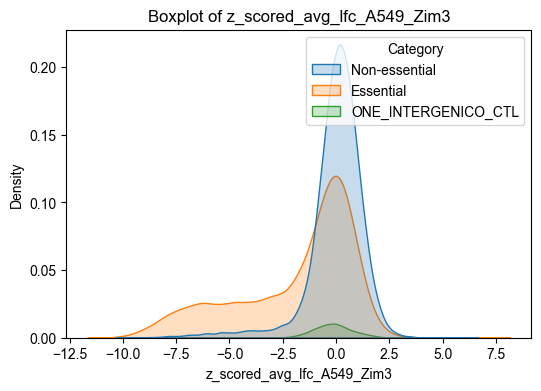

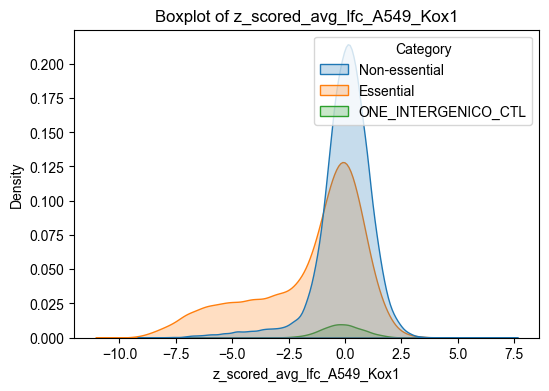

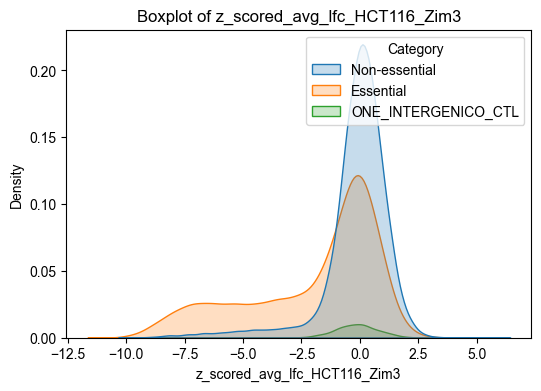

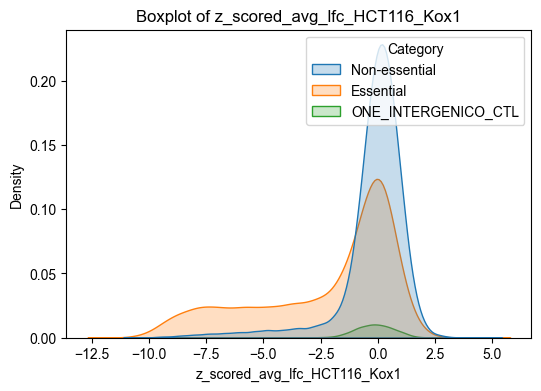

In [22]:
for var in ['z_scored_avg_lfc_A549_Zim3',
       'z_scored_avg_lfc_A549_Kox1', 
       'z_scored_avg_lfc_HCT116_Zim3',
       'z_scored_avg_lfc_HCT116_Kox1']:
    plt.figure(figsize=(6, 4))
    #sns.boxplot(merged_df, y=var, hue = 'Category')
    sns.kdeplot(data=merged_df_no_overlap, x=var, hue="Category", fill=True)
    plt.title(f'Boxplot of {var}')
    plt.show()

In [23]:


merged_df_no_overlap['all below Z -2'] = (merged_df_no_overlap[['z_scored_avg_lfc_A549_Zim3',
       'z_scored_avg_lfc_A549_Kox1', 
       'z_scored_avg_lfc_HCT116_Zim3',
       'z_scored_avg_lfc_HCT116_Kox1']] < -2).all(axis=1)


/var/folders/mj/lhpd16ys0cx2wkbhm7s0nfcm0000gp/T/ipykernel_78125/1564440154.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_no_overlap['all below Z -2'] = (merged_df_no_overlap[['z_scored_avg_lfc_A549_Zim3',


In [24]:

merged_df_no_overlap['last8_seq'] = [seq[12:20] for seq in merged_df_no_overlap['sgRNA Sequence']]


/var/folders/mj/lhpd16ys0cx2wkbhm7s0nfcm0000gp/T/ipykernel_78125/237173945.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_no_overlap['last8_seq'] = [seq[12:20] for seq in merged_df_no_overlap['sgRNA Sequence']]


In [27]:
merged_df_no_overlap['last8_seq'].value_counts()

last8_seq
GGCGGCGG    47
GGCGGGGC    40
GGGGGAGG    32
GCCGGGCG    31
GGGCGGGG    27
            ..
TTAACCCA     1
TGGAACAG     1
CCTGCATT     1
TAACAGCA     1
GCAATGAG     1
Name: count, Length: 39238, dtype: int64

In [29]:
merged_df_noness_no_overlap = merged_df_no_overlap[merged_df_no_overlap['Category'] == 'Non-essential']

In [30]:
merged_df_noness_no_overlap['last8_seq'].value_counts()

last8_seq
GGGGGAGG    17
GGGGAGGG    15
GGGGCTGG    14
GGCGGCGG    14
GCAGCAGC    12
            ..
AAGATGCT     1
AGGACTCG     1
GCTGACCC     1
GCGCCTCA     1
GCAATGAG     1
Name: count, Length: 25745, dtype: int64

In [31]:
merged_df_noness_no_overlap['z_scored_avg_lfc_A549'] = merged_df_noness_no_overlap.loc[:,['z_scored_avg_lfc_A549_Zim3', 'z_scored_avg_lfc_A549_Kox1']].mean(axis=1)
merged_df_noness_no_overlap['z_scored_avg_lfc_HCT116'] = merged_df_noness_no_overlap.loc[:,['z_scored_avg_lfc_HCT116_Zim3', 'z_scored_avg_lfc_HCT116_Kox1']].mean(axis=1)


/var/folders/mj/lhpd16ys0cx2wkbhm7s0nfcm0000gp/T/ipykernel_78125/1977676202.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_noness_no_overlap['z_scored_avg_lfc_A549'] = merged_df_noness_no_overlap.loc[:,['z_scored_avg_lfc_A549_Zim3', 'z_scored_avg_lfc_A549_Kox1']].mean(axis=1)
/var/folders/mj/lhpd16ys0cx2wkbhm7s0nfcm0000gp/T/ipykernel_78125/1977676202.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_noness_no_overlap['z_scored_avg_lfc_HCT116'] = merged_df_noness_no_overlap.loc[:,[

In [32]:
merged_df_noness_no_overlap=merged_df_noness_no_overlap[['Target Gene Symbol', 'Category', 'TSS Position', 'sgRNA Sequence', 'On-Target Efficacy Score',
       'sgRNA \'Cut\' Site TSS Offset', 'TSS Bucket', 'last8_seq',
       'z_scored_avg_lfc_A549', 'z_scored_avg_lfc_HCT116']]

In [33]:
merged_df_noness_no_overlap.last8_seq.value_counts()

last8_seq
GGGGGAGG    17
GGGGAGGG    15
GGGGCTGG    14
GGCGGCGG    14
GCAGCAGC    12
            ..
AAGATGCT     1
AGGACTCG     1
GCTGACCC     1
GCGCCTCA     1
GCAATGAG     1
Name: count, Length: 25745, dtype: int64

In [34]:
merged_df_noness_no_overlap.Category.value_counts()

Category
Non-essential    43011
Name: count, dtype: int64

In [35]:

last8_seq_stat = merged_df_noness_no_overlap.groupby('last8_seq') \
       .agg({'last8_seq':'size', 'z_scored_avg_lfc_A549':'mean', 'z_scored_avg_lfc_HCT116': 'mean'}) \
       .rename(columns={'last8_seq':'count','z_scored_avg_lfc_A549':'mean_z_A549','z_scored_avg_lfc_HCT116':'mean_z_HCT116'}) \
       .reset_index()

In [51]:
last8_seq_stat['count'].value_counts()

count
1     15886
2      5841
3      2301
4       927
5       378
6       206
7        75
8        66
9        34
10       13
11       11
12        3
14        2
15        1
17        1
Name: count, dtype: int64

In [52]:
import seaborn as sns


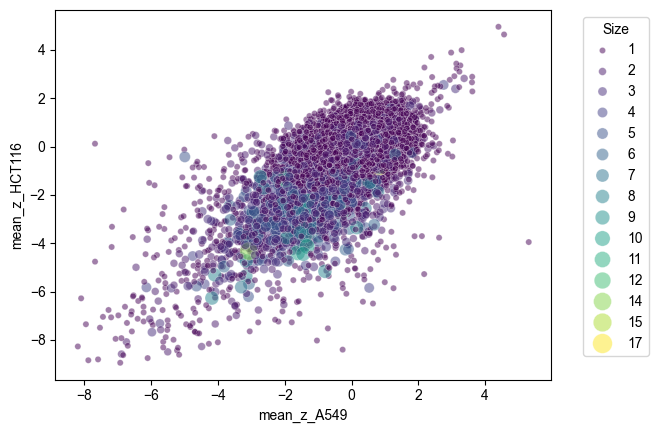

In [53]:
min, max = 20, 200
scatter = sns.scatterplot(
    data=last8_seq_stat,
    x="mean_z_A549",
    y="mean_z_HCT116",
    size="count",
    hue="count",
    alpha=0.5,
    sizes=(min, max),
    legend='full', palette='viridis'
)
handles, labels = scatter.get_legend_handles_labels()
size_legend = plt.legend(handles, labels, title='Size', bbox_to_anchor=(1.05, 1), loc='upper left')

# show the graph
plt.show()

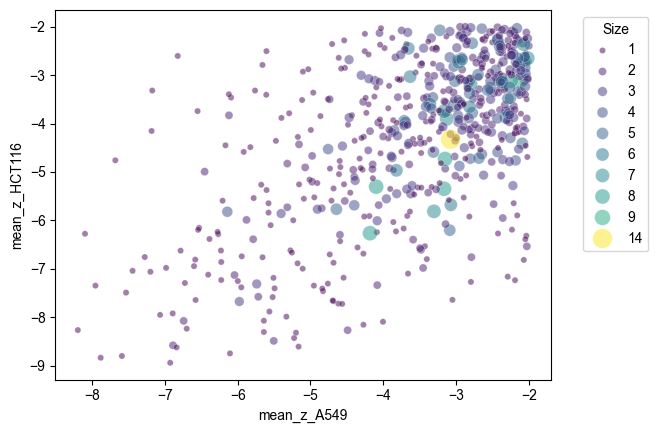

In [54]:

last8_seq_stat_selected = last8_seq_stat[(last8_seq_stat['mean_z_A549'] < -2) & (last8_seq_stat['mean_z_HCT116'] < -2)]

scatter = sns.scatterplot(
    data=last8_seq_stat_selected,
    x="mean_z_A549",
    y="mean_z_HCT116",
    size="count",
    hue="count",
    alpha=0.5,
    sizes=(min, max),
    legend='full', palette='viridis'
)
handles, labels = scatter.get_legend_handles_labels()
size_legend = plt.legend(handles, labels, title='Size', bbox_to_anchor=(1.05, 1), loc='upper left')

# show the graph
plt.show()

In [55]:
last8_seq_stat_selected.sort_values('count')

,last8_seq,count,mean_z_A549,mean_z_HCT116,NGG_NAG_Freq,CCN_CTN_Freq,NGG_Freq,CCN_Freq,CG_Content
25341,TTGGGAAA,1,-4.588645,-4.899793,1,0,1,0,0.375
16400,GGAATCCC,1,-4.141896,-5.130679,1,2,1,2,0.625
9311,CCGAAGGG,1,-5.507313,-7.188910,1,1,1,1,0.750
9346,CCGAGGCA,1,-7.198973,-7.063037,1,1,1,1,0.750
9368,CCGCACAC,1,-2.501239,-2.321956,0,1,0,1,0.750
...,...,...,...,...,...,...,...,...,...
13072,GAAGGAGG,8,-4.181674,-6.266026,2,0,2,0,0.625
13700,GAGAGGAG,8,-4.097331,-5.304717,2,0,1,0,0.625
8624,CCAGGAGG,8,-2.059983,-2.716629,2,1,2,1,0.750
8644,CCAGGGAG,9,-2.112834,-3.105608,2,1,1,1,0.750


In [56]:
last8_seq_stat_selected['count'].value_counts()

count
1     254
2     166
3      82
4      33
5      23
6       9
7       7
8       6
9       1
14      1
Name: count, dtype: int64

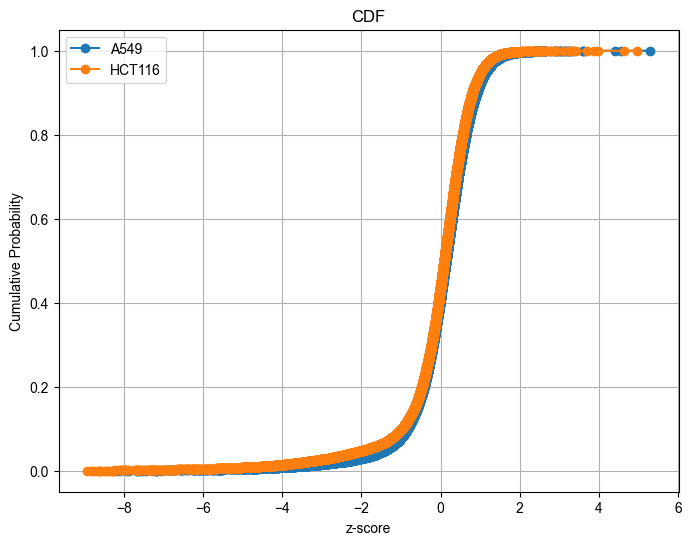

In [57]:


A549_sorted = np.sort(last8_seq_stat['mean_z_A549'])
HCT116_sorted = np.sort(last8_seq_stat['mean_z_HCT116'])

cdf_A549 = np.arange(1, len(A549_sorted) + 1) / len(A549_sorted)
cdf_HCT116 = np.arange(1, len(HCT116_sorted) + 1) / len(HCT116_sorted)

plt.figure(figsize=(8, 6))
plt.plot(A549_sorted, cdf_A549, label='A549', marker='o')
plt.plot(HCT116_sorted, cdf_HCT116, label='HCT116', marker='o')

plt.title('CDF')
plt.xlabel('z-score')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.grid(True)
plt.show()

In [58]:

def calculate_cg_content(sequence):
    cg_count = sequence.count('C') + sequence.count('G')
    return cg_count / len(sequence)
def calculate_motif_frequency(sequence, pattern):
    matches = re.findall(pattern, sequence)
    GG_start_match = sequence.startswith("GG")
    return len(matches) + GG_start_match


In [59]:
pattern_ngg_nag = r'[ATGC]GG|[ATGC]AG'
pattern_ccn_ctn = r'CC[ATGC]|CT[ATGC]'
pattern_ngg = r'[ATGC]GG'
pattern_ccn = r'CC[ATGC]'

last8_seq_stat['NGG_NAG_Freq'] = last8_seq_stat['last8_seq'].apply(lambda seq: calculate_motif_frequency(seq, pattern_ngg_nag))
last8_seq_stat['CCN_CTN_Freq'] = last8_seq_stat['last8_seq'].apply(lambda seq: calculate_motif_frequency(seq, pattern_ccn_ctn))

last8_seq_stat['NGG_Freq'] = last8_seq_stat['last8_seq'].apply(lambda seq: calculate_motif_frequency(seq, pattern_ngg))
last8_seq_stat['CCN_Freq'] = last8_seq_stat['last8_seq'].apply(lambda seq: calculate_motif_frequency(seq, pattern_ccn))

last8_seq_stat['CG_Content'] = last8_seq_stat['last8_seq'].apply(calculate_cg_content)


In [60]:
last8_seq_stat.NGG_Freq.value_counts()

NGG_Freq
0    15681
1     8324
2     1595
3      145
Name: count, dtype: int64

In [61]:
last8_seq_stat.NGG_NAG_Freq.value_counts()

NGG_NAG_Freq
1    12036
0     9796
2     3590
3      323
Name: count, dtype: int64

In [62]:
from sklearn.preprocessing import StandardScaler

kmeans = KMeans(n_clusters=3, random_state=100, n_init=50)
scaler = StandardScaler()
scaled_last8_seq_stat = scaler.fit_transform(last8_seq_stat[['mean_z_A549', 'mean_z_HCT116', 'NGG_Freq',
       'CCN_Freq', 'CG_Content']])

In [63]:
print(np.isnan(scaled_last8_seq_stat).sum())  # Should return 0


0


In [64]:
last8_seq_stat['Cluster'] = kmeans.fit_predict(scaled_last8_seq_stat)

In [65]:
last8_seq_stat

,last8_seq,count,mean_z_A549,mean_z_HCT116,NGG_NAG_Freq,CCN_CTN_Freq,NGG_Freq,CCN_Freq,CG_Content,Cluster
0,AAAAAAAG,2,0.722446,0.109050,1,0,0,0,0.125,1
1,AAAAAAAT,1,-0.218867,-0.080190,0,0,0,0,0.000,1
2,AAAAAACA,2,0.384990,0.510273,0,0,0,0,0.125,1
3,AAAAAACC,2,-0.597037,-0.699524,0,0,0,0,0.250,1
4,AAAAAAGA,2,-0.240334,0.135338,1,0,0,0,0.125,1
...,...,...,...,...,...,...,...,...,...,...
25740,TTTGTTGA,2,1.121640,1.023113,0,0,0,0,0.250,1
25741,TTTGTTGC,2,0.116380,0.716919,0,0,0,0,0.375,1
25742,TTTGTTGT,1,0.527632,-0.720006,0,0,0,0,0.250,1
25743,TTTGTTTC,2,-0.769984,-0.332403,0,0,0,0,0.250,1


In [66]:
last8_seq_stat.Cluster.value_counts()

Cluster
1    13118
0    11177
2     1450
Name: count, dtype: int64

In [67]:
cluster_stats = last8_seq_stat[['mean_z_A549', 'mean_z_HCT116', 'NGG_Freq',
       'CCN_Freq', 'CG_Content', 'Cluster']].groupby('Cluster').mean()
cluster_stats

,mean_z_A549,mean_z_HCT116,NGG_Freq,CCN_Freq,CG_Content
Cluster,,,,,
0,0.184570,0.084703,0.693836,0.807551,0.660352
1,0.151403,0.116260,0.203613,0.064796,0.393639
2,-2.313739,-3.224014,1.050345,0.650345,0.678621


In [68]:
last8_seq_stat.CG_Content.value_counts()

CG_Content
0.500    6633
0.625    5991
0.375    4941
0.750    3482
0.250    2394
0.875    1258
0.125     736
1.000     212
0.000      98
Name: count, dtype: int64

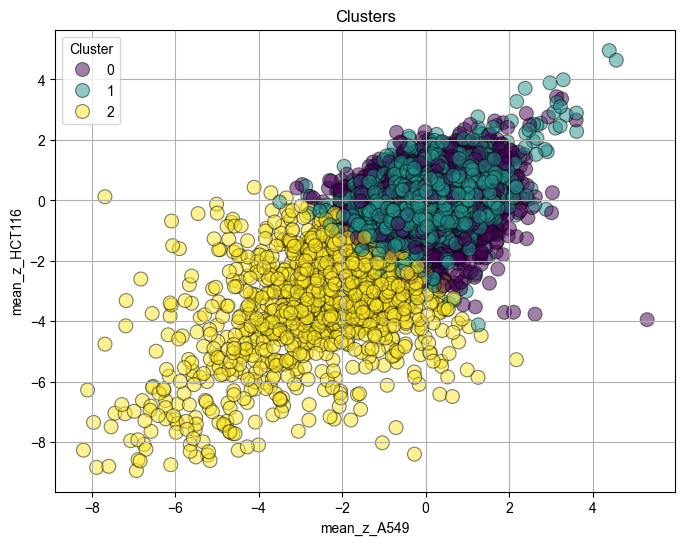

In [69]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='mean_z_A549', y='mean_z_HCT116', hue='Cluster', data=last8_seq_stat, 
                palette='viridis', s=100, edgecolor='k', alpha =0.5)

plt.title('Clusters')
plt.xlabel('mean_z_A549')
plt.ylabel('mean_z_HCT116')
plt.grid(True)

plt.show()

In [70]:
from scipy.stats import ttest_ind
feature_test = 'mean_z_A549'
cluster_0 = last8_seq_stat[last8_seq_stat['Cluster'] == 0][feature_test]
cluster_1 = last8_seq_stat[last8_seq_stat['Cluster'] == 1][feature_test]

t_stat, p_value = ttest_ind(cluster_0, cluster_1)

t_stat, p_value  #

(4.102720631535631, 4.0965092740047214e-05)

In [71]:
from sklearn.decomposition import PCA


In [72]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_last8_seq_stat)

last8_seq_stat['PCA1'] = pca_components[:, 0]
last8_seq_stat['PCA2'] = pca_components[:, 1]
pca.explained_variance_ratio_

array([0.38974858, 0.27690745])

In [73]:
sum(pca.explained_variance_ratio_)

0.6666560251485814

In [74]:
last8_seq_stat[['PCA1', 'PCA2', 'Cluster']]

,PCA1,PCA2,Cluster
0,-2.069752,1.014304,1
1,-1.842709,1.963772,1
2,-2.090093,1.024946,1
3,-0.689707,1.846443,1
4,-1.598781,1.563642,1
...,...,...,...
25740,-2.367435,0.044689,1
25741,-1.382781,0.460442,1
25742,-1.244707,1.199990,1
25743,-0.776517,1.776961,1


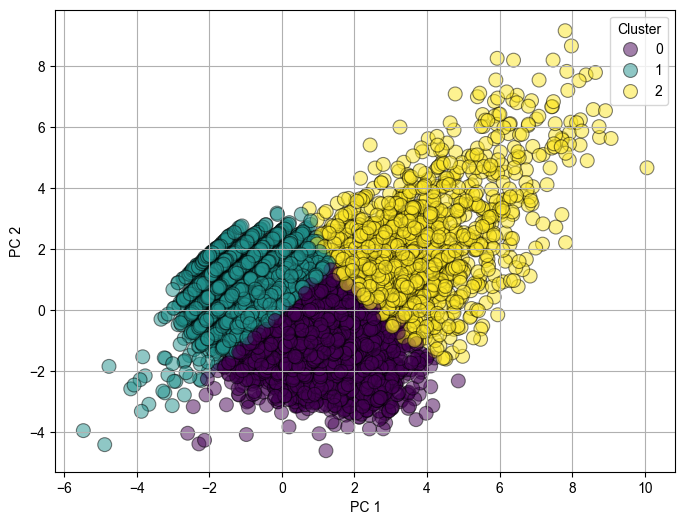

In [75]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', 
                data=last8_seq_stat, palette='viridis', s=100, edgecolor='k', alpha = 0.5)

plt.xlabel('PC 1')
plt.ylabel('PC 2')

plt.grid(True)
plt.show()


In [76]:
pca.components_

array([[-0.46061421, -0.49827467,  0.4176276 ,  0.34599384,  0.49541129],
       [-0.53506222, -0.48882801, -0.26119974, -0.43918808, -0.46221653]])

In [78]:
#Features with positive loadings are positively correlated with the principal component, 
#while features with negative loadings are inversely correlated.
last8_seq_stat
#no nag

,last8_seq,count,mean_z_A549,mean_z_HCT116,NGG_NAG_Freq,CCN_CTN_Freq,NGG_Freq,CCN_Freq,CG_Content,Cluster,PCA1,PCA2
0,AAAAAAAG,2,0.722446,0.109050,1,0,0,0,0.125,1,-2.069752,1.014304
1,AAAAAAAT,1,-0.218867,-0.080190,0,0,0,0,0.000,1,-1.842709,1.963772
2,AAAAAACA,2,0.384990,0.510273,0,0,0,0,0.125,1,-2.090093,1.024946
3,AAAAAACC,2,-0.597037,-0.699524,0,0,0,0,0.250,1,-0.689707,1.846443
4,AAAAAAGA,2,-0.240334,0.135338,1,0,0,0,0.125,1,-1.598781,1.563642
...,...,...,...,...,...,...,...,...,...,...,...,...
25740,TTTGTTGA,2,1.121640,1.023113,0,0,0,0,0.250,1,-2.367435,0.044689
25741,TTTGTTGC,2,0.116380,0.716919,0,0,0,0,0.375,1,-1.382781,0.460442
25742,TTTGTTGT,1,0.527632,-0.720006,0,0,0,0,0.250,1,-1.244707,1.199990
25743,TTTGTTTC,2,-0.769984,-0.332403,0,0,0,0,0.250,1,-0.776517,1.776961


The specific sequence in the promoter that positions the pol II is called the TATA box (consensus 5′-TATAAA-3′; some variants exist). Typically, the TATA box is located 25–30 bp upstream of the transcription start site (that is, −25 to −30 bp position), and for any given gene the position of the TATA box is fixed.


In [80]:
pattern_tata = r'TATAAA'

last8_seq_stat['TATA_Freq'] = last8_seq_stat['last8_seq'].apply(lambda seq: calculate_motif_frequency(seq, pattern_tata))


In [81]:
last8_seq_stat.TATA_Freq.value_counts()

TATA_Freq
0    23507
1     2238
Name: count, dtype: int64

In [47]:
#TATA, YY1, U1 snRNP, and Long Initiator (Long Inr).
#SP, NFY, ETS, ZNF143, NRF1, and CREB